# Frequentism, Samples, and the Bootstrap.

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## DATA AND MODELS

In [9]:
df = pd.read_csv("babyboom.dat.txt", header=None, sep='\s+', names=['24hrtime','sex','weight','minutes'])
df.head()

,24hrtime,sex,weight,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


In [10]:
df.minutes.mean()

788.7272727272727

In [11]:
df.corr()

,24hrtime,sex,weight,minutes
24hrtime,1.000000,0.028027,0.075636,0.999840
sex,0.028027,1.000000,0.228751,0.031815
weight,0.075636,0.228751,1.000000,0.079616
minutes,0.999840,0.031815,0.079616,1.000000


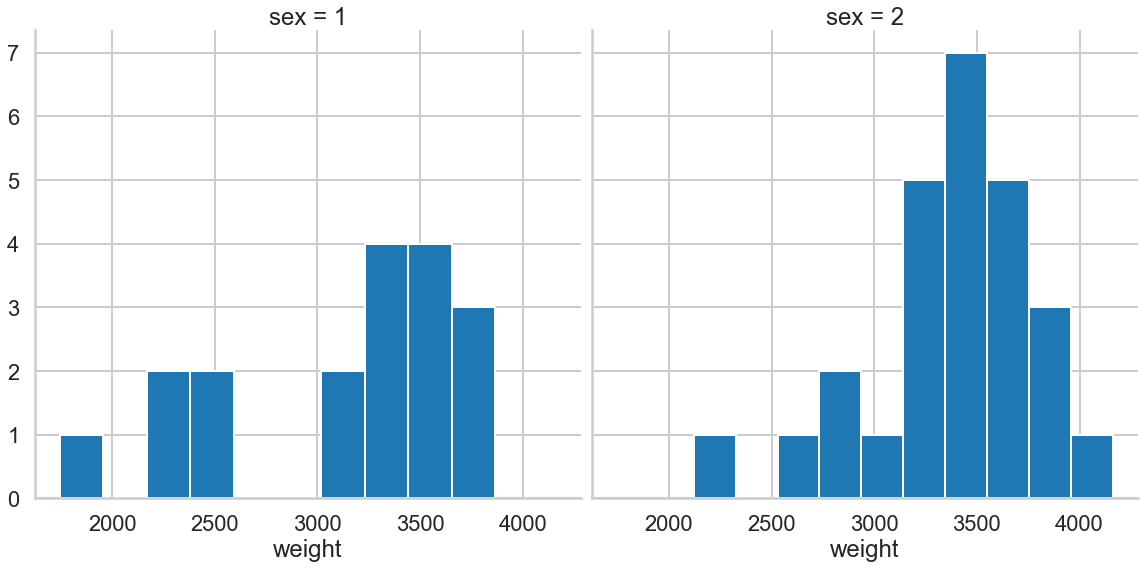

In [12]:
g = sns.FacetGrid(col="sex", data=df, height=8)
g.map(plt.hist, "weight")

Text(0, 0.5, 'exponential pdf')

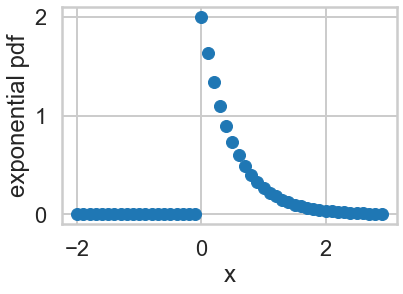

In [13]:
f = lambda x, l: l*np.exp(-l*x)*(x>0)
xpts=np.arange(-2,3,0.1)
plt.plot(xpts,f(xpts, 2),'o');
plt.xlabel("x")
plt.ylabel("exponential pdf")

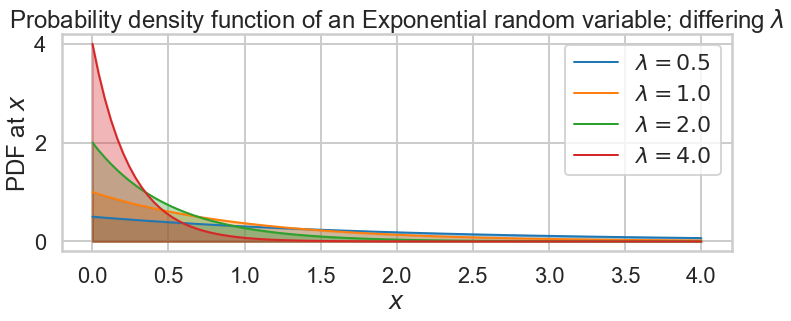

In [14]:
from scipy.stats import expon

x = np.linspace(0,4, 100)
colors=sns.color_palette()

lambda_ = [0.5, 1, 2, 4]
plt.figure(figsize=(12,4))
for l,c in zip(lambda_,colors):
    plt.plot(x, expon.pdf(x, scale=1./l), lw=2, 
                color=c, label = "$\lambda = %.1f$"%l)
    plt.fill_between(x, expon.pdf(x, scale=1./l), color=c, alpha = .33)
    
plt.legend()
plt.ylabel("PDF at $x$")
plt.xlabel("$x$")
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

### How would we draw from this distribution?

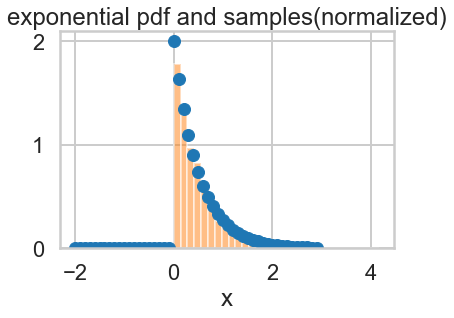

In [16]:
from scipy.stats import expon
plt.plot(xpts,expon.pdf(xpts, scale=1./2.),'o')
plt.hist(expon.rvs(size=1000, scale=1./2.), density=True, alpha=0.5, bins=30);
plt.xlabel("x")
plt.title("exponential pdf and samples(normalized)");

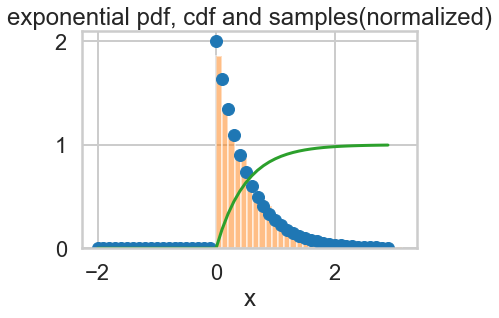

In [18]:
rv = expon(scale=0.5)
plt.plot(xpts,rv.pdf(xpts),'o')
plt.hist(rv.rvs(size=1000), density=True, alpha=0.5, bins=30);
plt.plot(xpts, rv.cdf(xpts));
plt.xlabel("x")
plt.title("exponential pdf, cdf and samples(normalized)");

### Understanding our data using a distribution

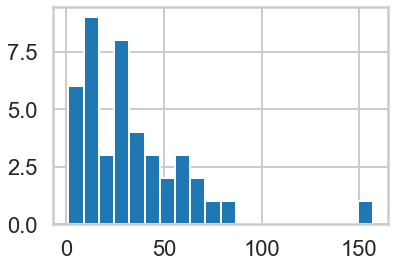

In [19]:
timediffs = df.minutes.diff()[1:]
timediffs.hist(bins=20);

In [21]:
lambda_from_mean = 1./timediffs.mean()
print(lambda_from_mean, 1./lambda_from_mean)

0.03006993006993007 33.25581395348837


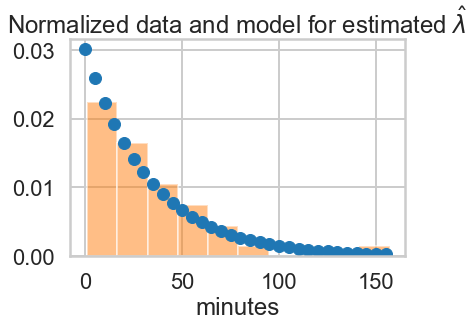

In [23]:
minutes=np.arange(0, 160, 5)
rv = expon(scale=1./lambda_from_mean)
plt.plot(minutes,rv.pdf(minutes),'o')
timediffs.hist(density=True, alpha=0.5);
plt.xlabel("minutes");
plt.title("Normalized data and model for estimated $\hat{\lambda}$");

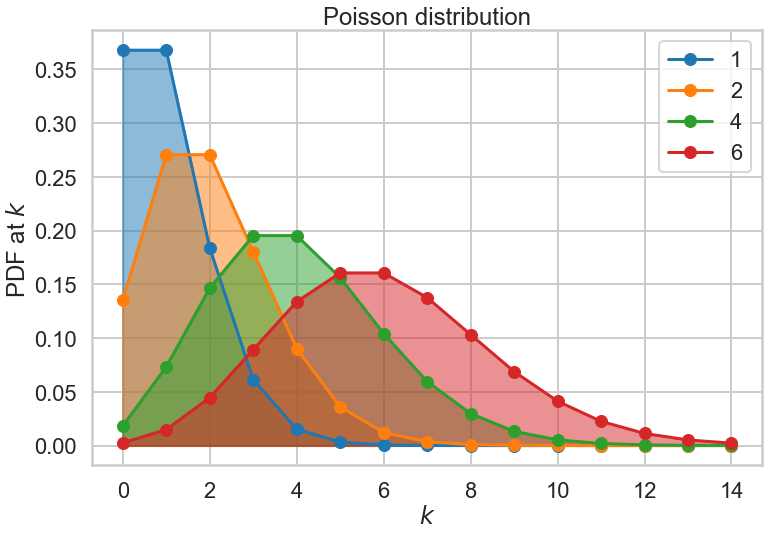

In [24]:
from scipy.stats import poisson
k = np.arange(15)
plt.figure(figsize=(12,8))
for i, lambda_ in enumerate([1, 2, 4, 6]):
    plt.plot(k, poisson.pmf(k, lambda_), '-o', label=lambda_, color=colors[i])
    plt.fill_between(k, poisson.pmf(k, lambda_), color=colors[i], alpha=0.5)
    plt.legend()
plt.title("Poisson distribution")
plt.ylabel("PDF at $k$")
plt.xlabel("$k$");

In [25]:
per_hour = df.minutes // 60
num_births_per_hour=df.groupby(per_hour).minutes.count()
num_births_per_hour

minutes
0     1
1     3
2     1
4     4
7     2
8     2
9     1
10    3
11    1
12    2
13    1
14    4
15    1
16    2
17    1
18    3
19    4
20    3
21    2
22    1
23    2
Name: minutes, dtype: int64

In [26]:
num_births_per_hour.mean()

2.0952380952380953

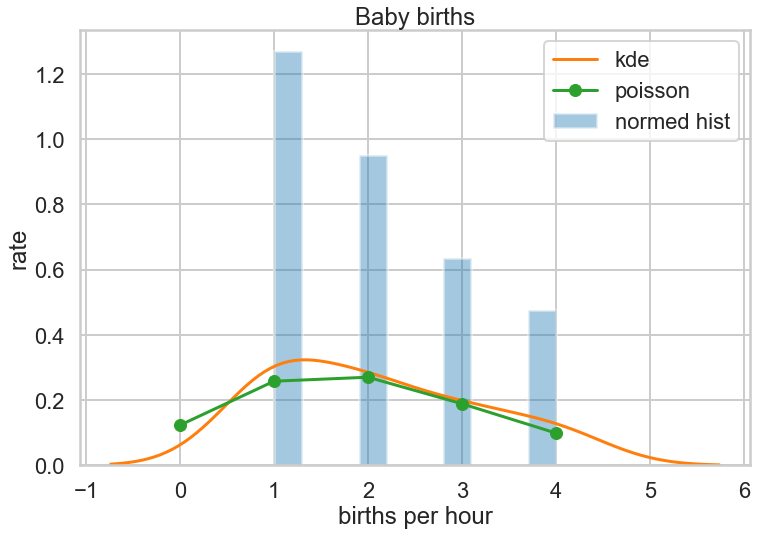

In [28]:
k = np.arange(5)
plt.figure(figsize=(12,8))
tcount=num_births_per_hour.sum()
plt.hist(num_births_per_hour, alpha=0.4,  lw=3, density=True, label="normed hist")
sns.kdeplot(num_births_per_hour, label="kde")
plt.plot(k, poisson.pmf(k, num_births_per_hour.mean()), '-o',label="poisson")
plt.title("Baby births")
plt.xlabel("births per hour")
plt.ylabel("rate")
plt.legend();

## FREQUENTIST STATISTICS¶

In [29]:
from scipy.stats.distributions import bernoulli
def throw_a_coin(n):
    brv = bernoulli(0.5)
    return brv.rvs(size=n)

In [30]:
def make_throws(number_of_samples, sample_size):
    start=np.zeros((number_of_samples, sample_size), dtype=int)
    for i in range(number_of_samples):
        start[i,:]=throw_a_coin(sample_size)
    return np.mean(start, axis=1)

In [32]:
sample_sizes=np.arange(1,1001,1)
sample_means = [make_throws(number_of_samples=200, sample_size=i) for i in sample_sizes]

In [33]:
mean_of_sample_means = [np.mean(means) for means in sample_means]

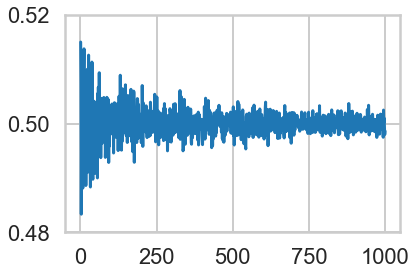

In [34]:
plt.plot(sample_sizes, mean_of_sample_means);
plt.ylim([0.480,0.520]);

### Non Parametric bootstrap

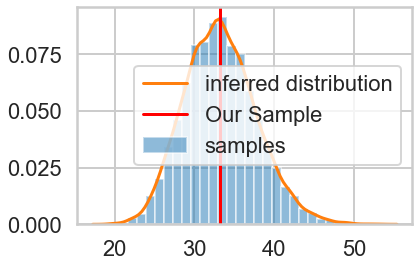

In [37]:
M_samples=10000
N_points = timediffs.shape[0]
bs_np = np.random.choice(timediffs, size=(M_samples, N_points))
sd_mean=np.mean(bs_np, axis=1)
sd_std=np.std(bs_np, axis=1)
plt.hist(sd_mean, bins=30, density=True, alpha=0.5,label="samples");
sns.kdeplot(sd_mean, label="inferred distribution")
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

### Parametric Bootstrap

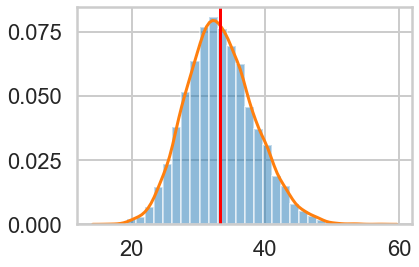

In [38]:
rv = expon(scale=1./lambda_from_mean)
M_samples=10000
N_points = timediffs.shape[0]
bs_p = rv.rvs(size=(M_samples, N_points))
sd_mean_p=np.mean(bs_p, axis=1)
sd_std_p=np.std(bs_p, axis=1)
plt.hist(sd_mean_p, bins=30, density=True, alpha=0.5);
sns.kdeplot(sd_mean_p);
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')